<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-packages-and-data" data-toc-modified-id="Load-packages-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load packages and data</a></span></li><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dimensionality Reduction</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#SVM-with-RBF-Kernel" data-toc-modified-id="SVM-with-RBF-Kernel-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>SVM with RBF-Kernel</a></span></li></ul></li></ul></div>

## Overview
This notebook estimates the more computationally expensive model (those that I could not train within 1-2 days on my laptop). I pursue four strategies to make estimating these more complex models feasible: Using only a subset of observations (training set size of 100,000 observations), reducing the number of features by about three quarters using principal component analysis, using a single validation set rather than using k-fold cross-validation, and running the notebook on AWS to use more powerful hardware.

## Load packages and data

In [1]:
import pdb 
import glob
import copy
import math
import pickle
import csv

import boto3
import uuid
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, pyll

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, StratifiedShuffleSplit, ShuffleSplit, \
    cross_val_score, StratifiedKFold

from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression, \
#     LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

We will use Boto 3 again to interact with S3 from our notebook.

In [2]:
# Create boto3 resource to interact with S3
s3 = boto3.resource('s3')

In the previous notebook, we uploaded our preprocessed data from the local machine to a S3 bucket. Let's now download these data to our EC2 instance.

In [ ]:
# Create folder to store data
!mkdir data_processed  

# Download files from S3 bucket
bucket_name = 'lending-club-a7b2c3e3-07f7-4444-b258-5bb63c282398'
filenames = ['X_train', 'X_test', 'y_train', 'y_test', 'feature_names']
for filename in filenames:
    s3.Object(bucket_name, f'{filename}.joblib') \
        .download_file(f'data_processed/{filename}.joblib')

Now we can load the data from disk.

In [3]:
# Load preprocessed training and test set, incl. feature names 
X_train = joblib.load('data_processed/X_train.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
feature_names = joblib.load('data_processed/feature_names.joblib')

Since the full data set is too large to fit a SVM with RBF or polynomial kernel, we create smaller subsets with 125,000 observations for the training set (only 100,000 of which will be used for training, the remaining will be used for validation) and 20,000 observations for the test set.

In [5]:
# Create smaller subsets from data for SVMs
X_train_s, y_train_s = resample(
    X_train, y_train, 
    replace=False, n_samples=100000, random_state=1)
    
# X_test_s, y_test_s = resample(
#     X_test, y_test, 
#     replace=False, n_samples=20000, random_state=1)

## Dimensionality Reduction

Another step to make the models less computationally expensive is to reduce the dimensionality of the data set.  To that end, let's perform principal component analysis to determine whether the data lie in a lower dimensional subspace. 

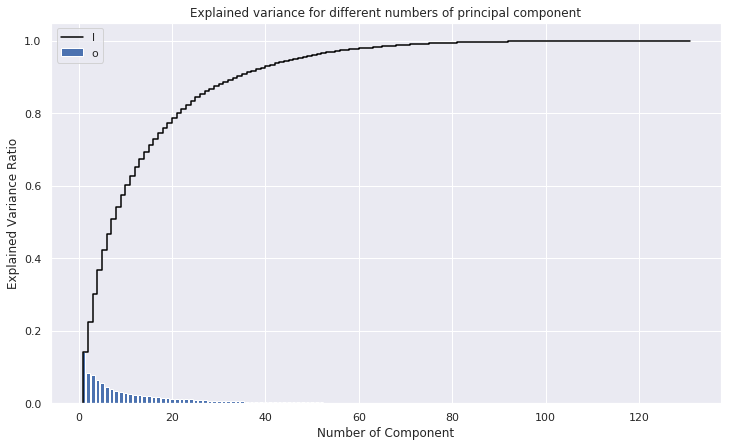

In [18]:
# Use PCA to assess whether features lie in lower-dimensional subspace
pca = PCA()
pca.fit(X_train)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Cumulative and per-component explained variance')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

The above plot shows the explained variance for principal component (blue bars), as well as the cumulative explained variance. This reveals that the first 20 principal components explain about 80% of the variance, and the first 50 principal components explain roughly 95% of the variance. 

I thus decide that the first 30 principal components, which explain close to 90% of the variance, give a good-enough lower-dimensional representation of the data. This reduction number of dimensions by over three quarters should make the models considerably faster to train, and thus allows us to use a larger sample size.

In [6]:
# Project data onto the first 30 principal components
pca = PCA(n_components=30)
X_train_pc = pca.fit_transform(X_train_s) 
X_test_pc = pca.transform(X_test_s)

In [7]:
# Check
X_train_pc.shape

(100000, 30)

## Predictive models

Before proceeding to training the models, I switch to a more powerful EC2 instance type.  

First note that the code is single-threaded.  For previous models, multi-threading was achieve through scikit-learn's cross validator. However, I use a single validation set for these more complex models, trading a slightly higher variance in the validation score for considerable savings in computation. Hyperopt does not natively support parallelization.

Secondly note that my models – SVM's with RBF and polynomial kernels – are also very memory-intensive; or put more precisely, by dedicating a lot of memory, we are able to achieve a considerable speed-up.

With these considerations in mind, I chose a r5.large instance, as it offered the largest amount of memory (16GB) and one of the highest computational capacities (9 ECUs) of all instances with one or two virtual CPUs.  While one  CPU would have been sufficient, none of these instances offered enough memory.

### SVM with RBF-Kernel

The strength of an SVM with an RBF kernel is coded modeling non-linear relationships. However, it does not scale well (according to scikit-learn's documentation, 

We will again use a log normal distribution for gamma, the neighborhood size. For the distribution's center, we use scikit-learn's default value, the inverse of the number of features. In our case this amounts to 1/30 (remember that we are using the principal components). One potential point of confusion is that hyperopt uses the *natutural* exponential function, whereas np.logspace uses base 10. Therefore, we use log(1/30) as the center parameter. Setting the variance parameter is less intuitive, so I simply experiment with different values and observe the location of the upper and lower quartiles, as well as minimum and maximum. I choose 3, which results with most values falling within the commonly used range of 0.01.

Descriptive statistics:
 count    1.000000e+03
mean     9.456460e+00
std      1.577441e+02
min      2.745386e-07
5%       9.630072e-05
50%      2.852804e-02
95%      1.266645e+01
max      4.906266e+03
dtype: float64


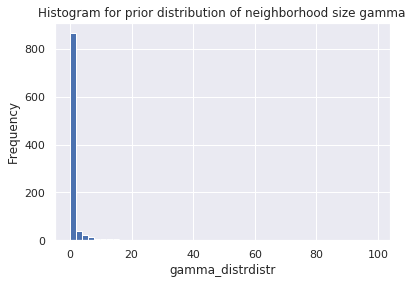

In [15]:
# Inspect prior distribution for gamma
gamma_distrdistr = hp.lognormal('C', np.log(1/30), 3.5)
samples = [pyll.stochastic.sample(gamma_distrdistr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting 
samples = list(filter(lambda x: x<100, samples))
# Plot
# sns.distplot(pd.Series(samples))
pd.Series(samples).plot(kind='hist', bins=50)
# plt.xlim([0,1000])
plt.xlabel('gamma_distrdistr')
plt.title('Histogram for prior distribution of neighborhood size gamma')
plt.show()

For the regularization parameter C, we will also use a lognormal distribution. Since we want to center it at 1, we can simply pass a mean parameter of 0. To find the scale parameter, we experiment again to find reasonable values. Again, a common range is 0.01 to 100. I choose a variance parameter of 5, but below set an upper boundary of 10 because larger values take longer to train (up to an order of magnitude).  Since lognormal gives distributions are characterized by large positive outliers, and since the model is already computationally expensive, setting this upper threshold is important.  As discussed in a previous notebook, hyperopt does not support setting upper or lower bounds by default.  Therefore, I write a function that adjusts the samples before passing them to the optimization, as well as before using the optimal parameters in other ways.

Descriptive statistics:
 count    1000.000000
mean       49.021006
std       303.815865
min         0.000083
5%          0.007126
50%         1.051820
95%       134.071433
max      4821.780629
dtype: float64


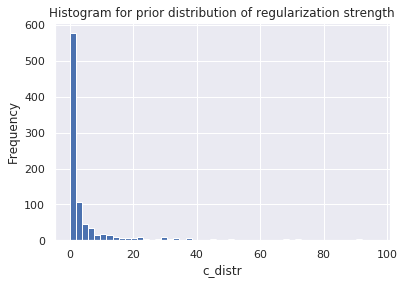

In [12]:
# Inspect prior distribution for C
c_distr = hp.lognormal('C', 0, 3)
samples = [pyll.stochastic.sample(c_distr) for i in range(1000)]

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe(percentiles=[0.05, 0.5, 0.95]))

# Discard outliers before plotting
samples = list(filter(lambda x: x<100, samples))
# Plot
pd.Series(samples).plot(kind='hist', bins=50)
plt.xlabel('c_distr')
plt.title('Histogram for prior distribution of regularization strength')
plt.show()

In [8]:
def adjust_params_svm_rbf(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Set min or max thresholds for parameters, where applicable
    if params['C'] >= 10:
        params['C'] = 10
        
    # Return modified parameters
    return params

In [9]:
# Function to carry out hyperparameter optimization
def find_best_hp(CLF, space, model_name, 
                 X_train, y_train, 
                 adjust_params=None,n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given classifier and search space."""
    
    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, CLF=CLF, 
                  progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""
        
        # Adjust parameters, if specified
        if adjust_params is not None:
            params = adjust_params(params)
    
        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)
    # Adjust best parameters, if specified
    if adjust_params is not None:
        best_params = adjust_params(best_params)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train, y_train)
    
    # Save model to disk
    joblib.dump(clf, 'saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)

In [ ]:
# Create directories to store models and progress files
!mkdir hp_progress saved_models

In [ ]:
MAX_EVALS=40

# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 12000,
    'class_weight': 'balanced',
    'C': hp.lognormal('C', 0, 3),
    'gamma': hp.lognormal('gamma', np.log(1/30), 3.5)}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_hp',
              X_train=X_train_pc, y_train=y_train_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=1)